In [19]:
import xarray as xr
import numpy as np

# Open the existing dataset
# ds = xr.open_dataset("existing_dataset.nc", mode="a")

# Define dimensions and coordinates
time = np.arange(10)  # Example time dimension
lat = np.linspace(-90, 90, 180)  # Example latitude
lon = np.linspace(-180, 180, 360)  # Example longitude

# Create the data for the new variable
cph_data = np.full((len(time), len(lat), len(lon)), -1, dtype='i2')
ctt_data=np.full((len(time)), -1, dtype='i2')
ds = xr.Dataset(
    coords={
        "time": time,
    },
)
# Add the new variable with attributes
ds["cph"] = xr.DataArray(
    cph_data,
    dims=("time", "lat", "lon"),
    attrs={
        "cell_methods": "time: point",
        "flag_meanings": "clear liquid ice",
        "flag_values": "0s, 1s, 2s",
        "missing_value": -1,
        "grid_mapping": "projection",
        "units": "1",
        "long_name": "Cloud Thermodynamic Phase",
        "standard_name": "thermodynamic_phase_of_cloud_water_particles_at_cloud_top",
    },
    coords={
        "lat": lat,
        "lon": lon, }
)

# Save the updated dataset back to the NetCDF file
# ds.to_netcdf("existing_dataset.nc", mode="a")

In [20]:
ds.lat.attrs= { "standard_name": "latitude",
                "long_name": "latitude" ,
                "units": "degrees_north" ,} 
ds.lon.attrs= { "standard_name": "longitude",
                "long_name": "longitude" ,
                "units": "degrees_east" ,} 

In [23]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 10, lat: 180, lon: 360)
Coordinates:
  * time     (time) int64 80B 0 1 2 3 4 5 6 7 8 9
  * lat      (lat) float64 1kB -90.0 -88.99 -87.99 -86.98 ... 87.99 88.99 90.0
  * lon      (lon) float64 3kB -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    cph      (time, lat, lon) int16 1MB -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1

In [52]:
sat_data=xr.load_dataset("/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040119193000405SVMSG01MD.nc")
aux_data=xr.load_dataset("/cluster/work/climate/dnikolo/CLAAS_Data/claas3_level2_aux_data.nc",decode_times=False)


In [51]:
Transformer=Projection_transformer()
Transformer.generate_lat_lon_prj(aux_data)
remaped=Transformer.remap_data(sat_data["cph"].data)

Bounds = [-81.12711304308402, 81.12650389547038, -81.07451709373741, 81.07635224475464]


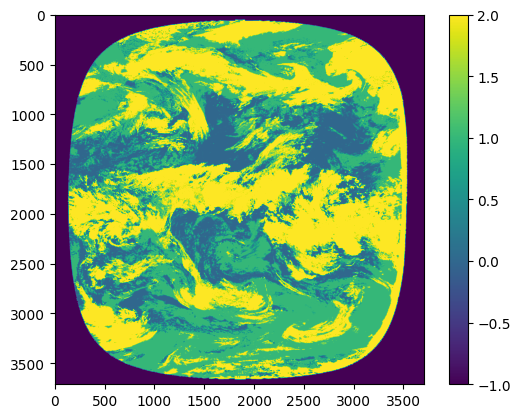

In [45]:
import matplotlib.pyplot as plt
plt.imshow(remaped[0,:,:])
plt.colorbar()

In [55]:
sat_data["cph"].data=remaped

In [2]:
import os
import xarray as xr
from Resample_data import Projection_transformer
from Resampling_file_search import filenames_to_resample

def resample_files(filenames_it):
    transformer= Projection_transformer()
    transformer.generate_lat_lon_prj(os.path.join(CLAAS_FP,'claas3_level2_aux_data.nc'))
    data= xr.load_mfdataset(filenames_it)
    data["cph"]



In [1]:
import os
filename="/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040119193000405SVMSG01MD.nc"


In [7]:
os.path.join(*(filename.split(os.path.sep)[-3:]))

'2004_01/CPH/CPPin20040119193000405SVMSG01MD.nc'

In [4]:
resample_target_filenames=filenames_to_resample()
print(resample_target_filenames)


{'2004_01'}
['/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120120000405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120120000405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120121500405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120123000405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120124500405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120130000405SVMSG01MD.nc']


In [5]:
data=xr.load_mfdataset(resample_target_filenames)

NameError: name 'generate_lat_lon_prj' is not defined

In [3]:
resample_target_filenames=filenames_to_resample()
print(resample_target_filenames)

{'2004_01'}
['/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120120000405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120120000405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120121500405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120123000405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120124500405SVMSG01MD.nc', '/cluster/work/climate/dnikolo/CLAAS_Data/Unprocessed_data/2004_01/CPH/CPPin20040120130000405SVMSG01MD.nc']


In [4]:
data=resample_files(resample_target_filenames)

In [9]:
print(data["cph"][:,:,:])

<xarray.DataArray 'cph' (time: 5, y: 3712, x: 3712)> Size: 276MB
dask.array<concatenate, shape=(5, 3712, 3712), dtype=float32, chunksize=(1, 1856, 1856), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 40B 2004-01-20T12:00:00 ... 2004-01-20T13:...
  * x        (x) float64 30kB -0.1556 -0.1555 -0.1554 ... 0.1554 0.1555 0.1556
  * y        (y) float64 30kB 0.1556 0.1555 0.1554 ... -0.1554 -0.1555 -0.1556
Attributes:
    grid_mapping:   projection
    flag_values:    [0 1 2]
    flag_meanings:  clear liquid ice
    standard_name:  thermodynamic_phase_of_cloud_water_particles_at_cloud_top
    long_name:      Cloud Thermodynamic Phase
    units:          1
    valid_range:    [0 2]
    cell_methods:   time: point
